# AUTHENTICATION

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID


'churn-pred-411712'

In [2]:
REGION = 'asia-south1'

# PACKAGES

In [3]:
from google.cloud import storage
from google.cloud import bigquery

import pandas as pd
from sklearn import datasets

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#CLIENTS

gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

In [5]:
#gcs
#bq

In [6]:
#CREATE A STORAGE BUCKET

# BUCKET = PROJECT_ID

In [7]:
BUCKET = gcs.bucket("churn-prediction-data")
BUCKET

<Bucket: churn-prediction-data>

In [8]:
#check contents of the bucket

blobs = BUCKET.list_blobs()
for blob in blobs:
    print(blob.name)

E Commerce Dataset.csv


In [9]:
#SET UP PERMISSIONS FOR THE SERVICE ACCOUNT TO  INTTERACT WITH OBJECT IN CLOUD STORAGE 

#CHECK AVAILABLE PERMISSIONS (Cloud Resource Manager API should be enabled)

# !gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

In [10]:
#GET ACCOUNT DETAILS

# SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
# SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
# SERVICE_ACCOUNT

In [11]:
#ENABLE CLOUD RESOURCE MANAGER API

# !gcloud services enable cloudresourcemanager.googleapis.com


In [12]:
#INSTALL KUBEFLOW PIPELINES

# !pip install kfp -U -q

In [13]:
# !pip install google-cloud-pipeline-components -U -q


In [14]:
#INSTALL AIPLATFORM PACKAGE

# !pip install googleapis-common-protos -U -q

In [15]:
# !pip install google-cloud-aiplatform -U -q

# SETTING UP BIGQUERY

In [16]:
#source data

BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'churn'
BQ_TABLE = 'churn'

EXPERIMENT = '01'

In [17]:
# Check if any datasets exist in BigQuery already

datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

churn


# DATASETS AND TABLES IN BIGQUERY

In [18]:
# # Create a new dataset in BigQuery if there are no datasets created

# ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
# ds.location = REGION
# ds.labels = {'experiment': f'{EXPERIMENT}'}
# ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [19]:
bucketDef = BUCKET
if storage.Blob(bucket = bucketDef, name = 'E Commerce Dataset.csv').exists(gcs):
    print(f'The file has already been created at: gs://{bucketDef.name}/{{"E Commerce Dataset.csv"}}')
# else:
#     source = bigquery.TableReference.from_string(BQ_SOURCE)
#     extract = bq.extract_table(source = source, destination_uris = [f'gs://{bucketDef.name}/{file}'])
#     print('Creating the export ...')
#     extract.result()
#     print(f'Exported the table to: gs://{bucketDef.name}/{file}')

The file has already been created at: gs://churn-prediction-data/{"E Commerce Dataset.csv"}


In [20]:
from google.cloud.exceptions import NotFound
try:
    table = bq.get_table(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')
    if table:
        print(f'The table already exists: {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')
except NotFound as error:
    print(f'Creating Table ...')
    destination = bigquery.TableReference.from_string(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")
    job_config = bigquery.LoadJobConfig(
        write_disposition = 'WRITE_TRUNCATE',
        source_format = bigquery.SourceFormat.CSV,
        autodetect = True,
        labels = {'experiment': f'{EXPERIMENT}'}
    )
    job = bq.load_table_from_uri(f'gs://{bucketDef.name}/{"E Commerce Dataset.csv"}', destination, job_config = job_config)
    job.result()
    print(f'Finished creating table: {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')

The table already exists: churn-pred-411712.churn.churn


In [21]:
#print(f"Direct Link To This Project In BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}")

__FETCHING DATA FROM STORAGE BUCKET__

In [22]:
# Get a reference to the file in the bucket
blob = gcs.bucket(bucketDef.name).blob("E Commerce Dataset.csv")
blob

<Blob: churn-prediction-data, E Commerce Dataset.csv, None>

In [23]:
df = pd.read_csv(blob.open("r"), encoding="utf-8")

# EDA

In [24]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [26]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


# VALUE COUNTS

In [27]:
for col in df.columns.to_list():
    print("\n------- {0} -------\n".format(col))
    print(df[col].value_counts())


------- CustomerID -------

CustomerID
50001    1
53751    1
53759    1
53758    1
53757    1
        ..
51876    1
51875    1
51874    1
51873    1
55630    1
Name: count, Length: 5630, dtype: int64

------- Churn -------

Churn
0    4682
1     948
Name: count, dtype: int64

------- Tenure -------

Tenure
1.0     690
0.0     508
8.0     263
9.0     247
7.0     221
10.0    213
5.0     204
4.0     203
3.0     195
11.0    194
6.0     183
12.0    182
13.0    181
14.0    176
2.0     167
15.0    159
16.0    149
19.0    140
18.0    123
20.0    109
17.0    106
23.0     89
21.0     84
22.0     76
24.0     75
28.0     70
30.0     66
27.0     66
26.0     60
25.0     59
29.0     55
31.0     49
50.0      1
60.0      1
51.0      1
61.0      1
Name: count, dtype: int64

------- PreferredLoginDevice -------

PreferredLoginDevice
Mobile Phone    2765
Computer        1634
Phone           1231
Name: count, dtype: int64

------- CityTier -------

CityTier
1    3666
3    1722
2     242
Name: count, dtype

# ADDRESSING DATA DUPLICATION

In [28]:
# In these 3 columns, there are similar categories with different names. For eg, 'mobile phone' and 'phone'

for col in ["PreferredLoginDevice", "PreferredPaymentMode", "PreferedOrderCat"]:
    print("\n------- {0} -------\n".format(col))
    print(df[col].value_counts())


------- PreferredLoginDevice -------

PreferredLoginDevice
Mobile Phone    2765
Computer        1634
Phone           1231
Name: count, dtype: int64

------- PreferredPaymentMode -------

PreferredPaymentMode
Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: count, dtype: int64

------- PreferedOrderCat -------

PreferedOrderCat
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: count, dtype: int64


In [29]:
# Replacing 'phone' with 'mobile phone' in PreferredLoginDevice 

df["PreferredLoginDevice"] = df["PreferredLoginDevice"].map(lambda x: "Mobile Phone" if x == "Phone" else x)

In [30]:
# Replacing 'CC' with 'Credit Card' and 'COD' with 'Cash on Delivery' in PreferredPaymentMode
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].map(lambda x: "Credit Card" if x == "CC" else x) 
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].map(lambda x: "Cash on Delivery" if x == "COD" else x)

# Replacing 'Mobile' with 'Mobile Phone' in PreferedOrderCat
df["PreferedOrderCat"] = df["PreferedOrderCat"].map(lambda x: "Mobile Phone" if x == "Mobile" else x)

In [31]:
for col in ["PreferredLoginDevice", "PreferredPaymentMode", "PreferedOrderCat"]:
    print("\n------- {0} -------\n".format(col))
    print(df[col].value_counts())


------- PreferredLoginDevice -------

PreferredLoginDevice
Mobile Phone    3996
Computer        1634
Name: count, dtype: int64

------- PreferredPaymentMode -------

PreferredPaymentMode
Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: count, dtype: int64

------- PreferedOrderCat -------

PreferedOrderCat
Mobile Phone          2080
Laptop & Accessory    2050
Fashion                826
Grocery                410
Others                 264
Name: count, dtype: int64


# NULL VALUES

In [32]:
# return only the columns that have null values

for col in df.columns.to_list():
    if df[col].isna().sum() > 0:
        print("\n{0} -------> {1}".format(col, round(df[col].isna().sum())))


Tenure -------> 264

WarehouseToHome -------> 251

HourSpendOnApp -------> 255

OrderAmountHikeFromlastYear -------> 265

CouponUsed -------> 256

OrderCount -------> 258

DaySinceLastOrder -------> 307


In [33]:
#Using forward fill to impute values

df['Tenure'] = df['Tenure'].ffill()

In [34]:
print(df['Tenure'])

0        4.0
1        4.0
2        4.0
3        0.0
4        0.0
        ... 
5625    10.0
5626    13.0
5627     1.0
5628    23.0
5629     8.0
Name: Tenure, Length: 5630, dtype: float64


In [35]:
for col in ['Tenure']:
    print("\n------- {0} -------\n".format(col))
    print(df['Tenure'].value_counts())


------- Tenure -------

Tenure
1.0     691
0.0     576
8.0     279
9.0     256
7.0     240
10.0    221
4.0     215
5.0     206
3.0     204
11.0    198
13.0    197
6.0     194
12.0    190
14.0    181
15.0    171
2.0     169
16.0    151
19.0    145
18.0    130
17.0    115
20.0    115
23.0     97
21.0     84
22.0     79
24.0     77
30.0     76
28.0     70
27.0     70
26.0     62
25.0     61
29.0     57
31.0     49
50.0      1
60.0      1
51.0      1
61.0      1
Name: count, dtype: int64


In [36]:
# Imputing the following columns with median

columns_to_impute = ['WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

# Impute missing values with medians, rounding to integers
df[columns_to_impute] = df[columns_to_impute].fillna(df[columns_to_impute].median().round())

In [37]:
# return only the columns that have null values

for col in df.columns.to_list():
    if df[col].isna().sum() > 0:
        print("\n{0} -------> {1}".format(col, round(df[col].isna().sum())))

__NO NULL VALUES FOUND.__

In [38]:
df = df.drop('CustomerID', axis=1)

In [39]:
df.dtypes

Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                   int64
dtype: object

# CONVERT CATEGORICAL COLUMNS TO NUMERICAL

In [40]:
categorical_cols = df.select_dtypes(include='object').columns

In [41]:
categorical_cols

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')

In [42]:
for col in categorical_cols:
    print("\n------- {0} -------\n".format(col))
    print(df[col].value_counts())


------- PreferredLoginDevice -------

PreferredLoginDevice
Mobile Phone    3996
Computer        1634
Name: count, dtype: int64

------- PreferredPaymentMode -------

PreferredPaymentMode
Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: count, dtype: int64

------- Gender -------

Gender
Male      3384
Female    2246
Name: count, dtype: int64

------- PreferedOrderCat -------

PreferedOrderCat
Mobile Phone          2080
Laptop & Accessory    2050
Fashion                826
Grocery                410
Others                 264
Name: count, dtype: int64

------- MaritalStatus -------

MaritalStatus
Married     2986
Single      1796
Divorced     848
Name: count, dtype: int64


In [43]:
# One-Hot Encoding for 'PreferredLoginDevice' and 'Gender' columns

df_encoded = pd.get_dummies(df, columns=["PreferredLoginDevice", "Gender"], drop_first=True)
print(df_encoded)

      Churn  Tenure  CityTier  WarehouseToHome PreferredPaymentMode   
0         1     4.0         3              6.0           Debit Card  \
1         1     4.0         1              8.0                  UPI   
2         1     4.0         1             30.0           Debit Card   
3         1     0.0         3             15.0           Debit Card   
4         1     0.0         1             12.0          Credit Card   
...     ...     ...       ...              ...                  ...   
5625      0    10.0         1             30.0          Credit Card   
5626      0    13.0         1             13.0          Credit Card   
5627      0     1.0         1             11.0           Debit Card   
5628      0    23.0         3              9.0          Credit Card   
5629      0     8.0         1             15.0          Credit Card   

      HourSpendOnApp  NumberOfDeviceRegistered    PreferedOrderCat   
0                3.0                         3  Laptop & Accessory  \
1      

In [44]:
# Convert data types to numeric
encoded_columns = ["PreferredLoginDevice_Mobile Phone", "Gender_Male"]
df_encoded[encoded_columns] = df_encoded[encoded_columns].astype('int64')
df_encoded

,Churn,Tenure,CityTier,WarehouseToHome,PreferredPaymentMode,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,Gender_Male
0,1,4.0,3,6.0,Debit Card,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160,1,0
1,1,4.0,1,8.0,UPI,3.0,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,121,1,1
2,1,4.0,1,30.0,Debit Card,2.0,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120,1,1
3,1,0.0,3,15.0,Debit Card,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134,1,1
4,1,0.0,1,12.0,Credit Card,3.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,1.0,3.0,130,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,1,30.0,Credit Card,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,151,0,1
5626,0,13.0,1,13.0,Credit Card,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,3.0,225,1,1
5627,0,1.0,1,11.0,Debit Card,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186,1,1
5628,0,23.0,3,9.0,Credit Card,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,179,0,1


In [45]:
df_encoded.dtypes

Churn                                  int64
Tenure                               float64
CityTier                               int64
WarehouseToHome                      float64
PreferredPaymentMode                  object
HourSpendOnApp                       float64
NumberOfDeviceRegistered               int64
PreferedOrderCat                      object
SatisfactionScore                      int64
MaritalStatus                         object
NumberOfAddress                        int64
Complain                               int64
OrderAmountHikeFromlastYear          float64
CouponUsed                           float64
OrderCount                           float64
DaySinceLastOrder                    float64
CashbackAmount                         int64
PreferredLoginDevice_Mobile Phone      int64
Gender_Male                            int64
dtype: object

In [46]:
# listing existing categorical columns that have multiple categories
cat_cols = df_encoded.select_dtypes(include='object').columns
cat_cols

Index(['PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus'], dtype='object')

In [47]:
# converting multi-categorical columns into binary using One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns = cat_cols)

In [48]:
df_encoded.columns

Index(['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile Phone', 'Gender_Male',
       'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Fashion', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

In [49]:
encoded_columns_new = ['PreferredPaymentMode_Cash on Delivery', 'PreferredPaymentMode_Credit Card', 
                       'PreferredPaymentMode_Debit Card', 'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
                       'PreferedOrderCat_Fashion', 'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory', 
                       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others', 'MaritalStatus_Divorced',
                       'MaritalStatus_Married', 'MaritalStatus_Single']

In [50]:
#converting encoded columns into integer type

df_encoded[encoded_columns_new] = df_encoded[encoded_columns_new].astype('int64')
df_encoded

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,...,0,0,0,0,1,0,0,0,0,1
1,1,4.0,1,8.0,3.0,4,3,7,1,15.0,...,0,1,0,0,0,1,0,0,0,1
2,1,4.0,1,30.0,2.0,4,3,6,1,14.0,...,0,0,0,0,0,1,0,0,0,1
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,...,0,0,0,0,1,0,0,0,0,1
4,1,0.0,1,12.0,3.0,3,5,3,0,11.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,1,30.0,3.0,2,1,6,0,18.0,...,0,0,0,0,1,0,0,0,1,0
5626,0,13.0,1,13.0,3.0,5,5,6,0,16.0,...,0,0,1,0,0,0,0,0,1,0
5627,0,1.0,1,11.0,3.0,2,4,3,1,21.0,...,0,0,0,0,1,0,0,0,1,0
5628,0,23.0,3,9.0,4.0,5,4,4,0,15.0,...,0,0,0,0,1,0,0,0,1,0


# DATA VISUALIZATION

__First, we check the normality of the features__

In [51]:
# Function to check normality using Shapiro-Wilk test

from scipy.stats import shapiro

def check_normality(df):
    normality_results = {}
    for column in df.columns:
        stat, p_value = shapiro(df[column])
        normality_results[column] = {'Stat': stat, 'p-value': p_value, 'Normal': p_value > 0.05}
    return normality_results

normality_results = check_normality(df_encoded)
normality_results

c:\Users\mayur\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'Churn': {'Stat': 0.45170503854751587, 'p-value': 0.0, 'Normal': False},
 'Tenure': {'Stat': 0.9204967617988586, 'p-value': 0.0, 'Normal': False},
 'CityTier': {'Stat': 0.6199389696121216, 'p-value': 0.0, 'Normal': False},
 'WarehouseToHome': {'Stat': 0.8592151403427124,
  'p-value': 0.0,
  'Normal': False},
 'HourSpendOnApp': {'Stat': 0.822528600692749,
  'p-value': 0.0,
  'Normal': False},
 'NumberOfDeviceRegistered': {'Stat': 0.8971222043037415,
  'p-value': 0.0,
  'Normal': False},
 'SatisfactionScore': {'Stat': 0.885958731174469,
  'p-value': 0.0,
  'Normal': False},
 'NumberOfAddress': {'Stat': 0.8765546679496765,
  'p-value': 0.0,
  'Normal': False},
 'Complain': {'Stat': 0.5655543804168701, 'p-value': 0.0, 'Normal': False},
 'OrderAmountHikeFromlastYear': {'Stat': 0.9158767461776733,
  'p-value': 0.0,
  'Normal': False},
 'CouponUsed': {'Stat': 0.7162956595420837, 'p-value': 0.0, 'Normal': False},
 'OrderCount': {'Stat': 0.6659093499183655, 'p-value': 0.0, 'Normal': False},
 '

__None of the features are normally disributed, but are significant for model building.__

__CHECKING FOR OUTLIERS__

In [52]:
# Visualizing outliers; not considering the target variable 'Churn' and OH encoded features 

import plotly.io as pio

fig = px.box(df_encoded, y=['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
             labels={
                     "variable": "Columns with numerical values",
                     "value": "Values",
                 },
             template="plotly_dark",
             title="Outliers Visulaization")
fig.update_layout(title_x = 0.5,)

fig.write_image('outliers_plot.png')

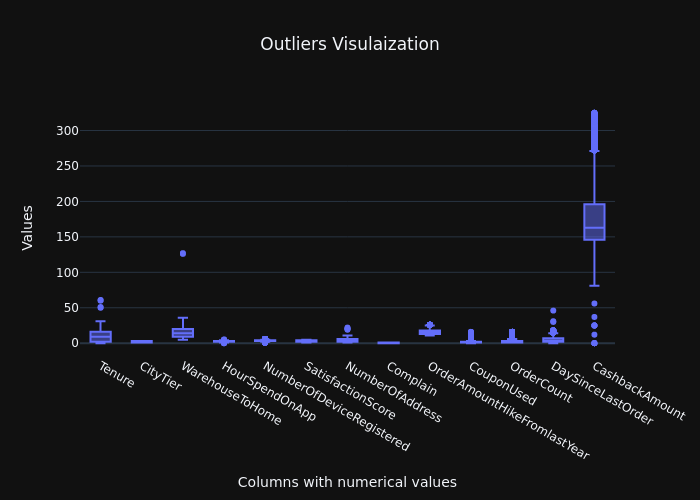

In [53]:
from IPython.display import Image, display

display(Image(filename = "outliers_plot.png"))

__Removing all suspected outliers__

In [52]:
# Function to remove outliers using Z-score

from scipy.stats import zscore

def remove_outliers(df_encoded, threshold=2):
    z_scores = zscore(df_encoded)
    abs_z_scores = abs(df_encoded)
    outliers = (abs_z_scores > threshold).all(axis=1)
    df_no_outliers = df_encoded[~outliers]
    return df_no_outliers


df_no_outliers = remove_outliers(df_encoded)

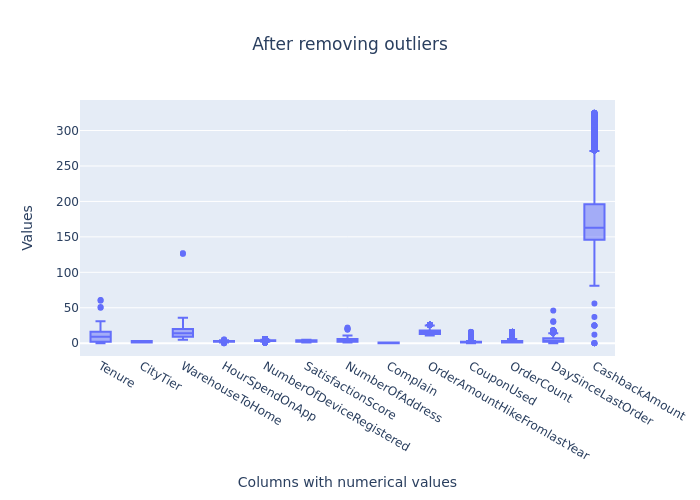

In [55]:
# Verifying by using a boxplot, not considering the target variable 'Churn' and OH encoded features 


fig_2 = px.box(df_no_outliers, y=['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
             labels={
                     "variable": "Columns with numerical values",
                     "value": "Values",
                 },
             #template="plotly_dark",
             title="After removing outliers")
fig_2.update_layout(title_x = 0.5,)

fig_2.write_image('no_outliers.png')

display(Image(filename = "no_outliers.png"))

__It seems that there are no significant outliers as the data points seem to be less than the threshold (3 standard deviations from the mean).__

__Visualizing distribution of the features.__

In [54]:
# from scipy.stats import probplot

# for column in ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
#        'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
#        'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
#        'DaySinceLastOrder', 'CashbackAmount']:


#     # Visualization
#     plt.figure(figsize=(12, 6))

#     # Distribution
#     plt.subplot(1, 2, 1)
#     sns.histplot(df_encoded[column], kde=True, color='blue')
#     plt.title(f'Distribution - {column}')

In [55]:
# Select all numerical columns except 'Churn'

numeric_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns.difference(['Churn'])
numeric_columns

Index(['CashbackAmount', 'CityTier', 'Complain', 'CouponUsed',
       'DaySinceLastOrder', 'Gender_Male', 'HourSpendOnApp',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'NumberOfAddress', 'NumberOfDeviceRegistered',
       'OrderAmountHikeFromlastYear', 'OrderCount', 'PreferedOrderCat_Fashion',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory',
       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others',
       'PreferredLoginDevice_Mobile Phone',
       'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome'],
      dtype='object')

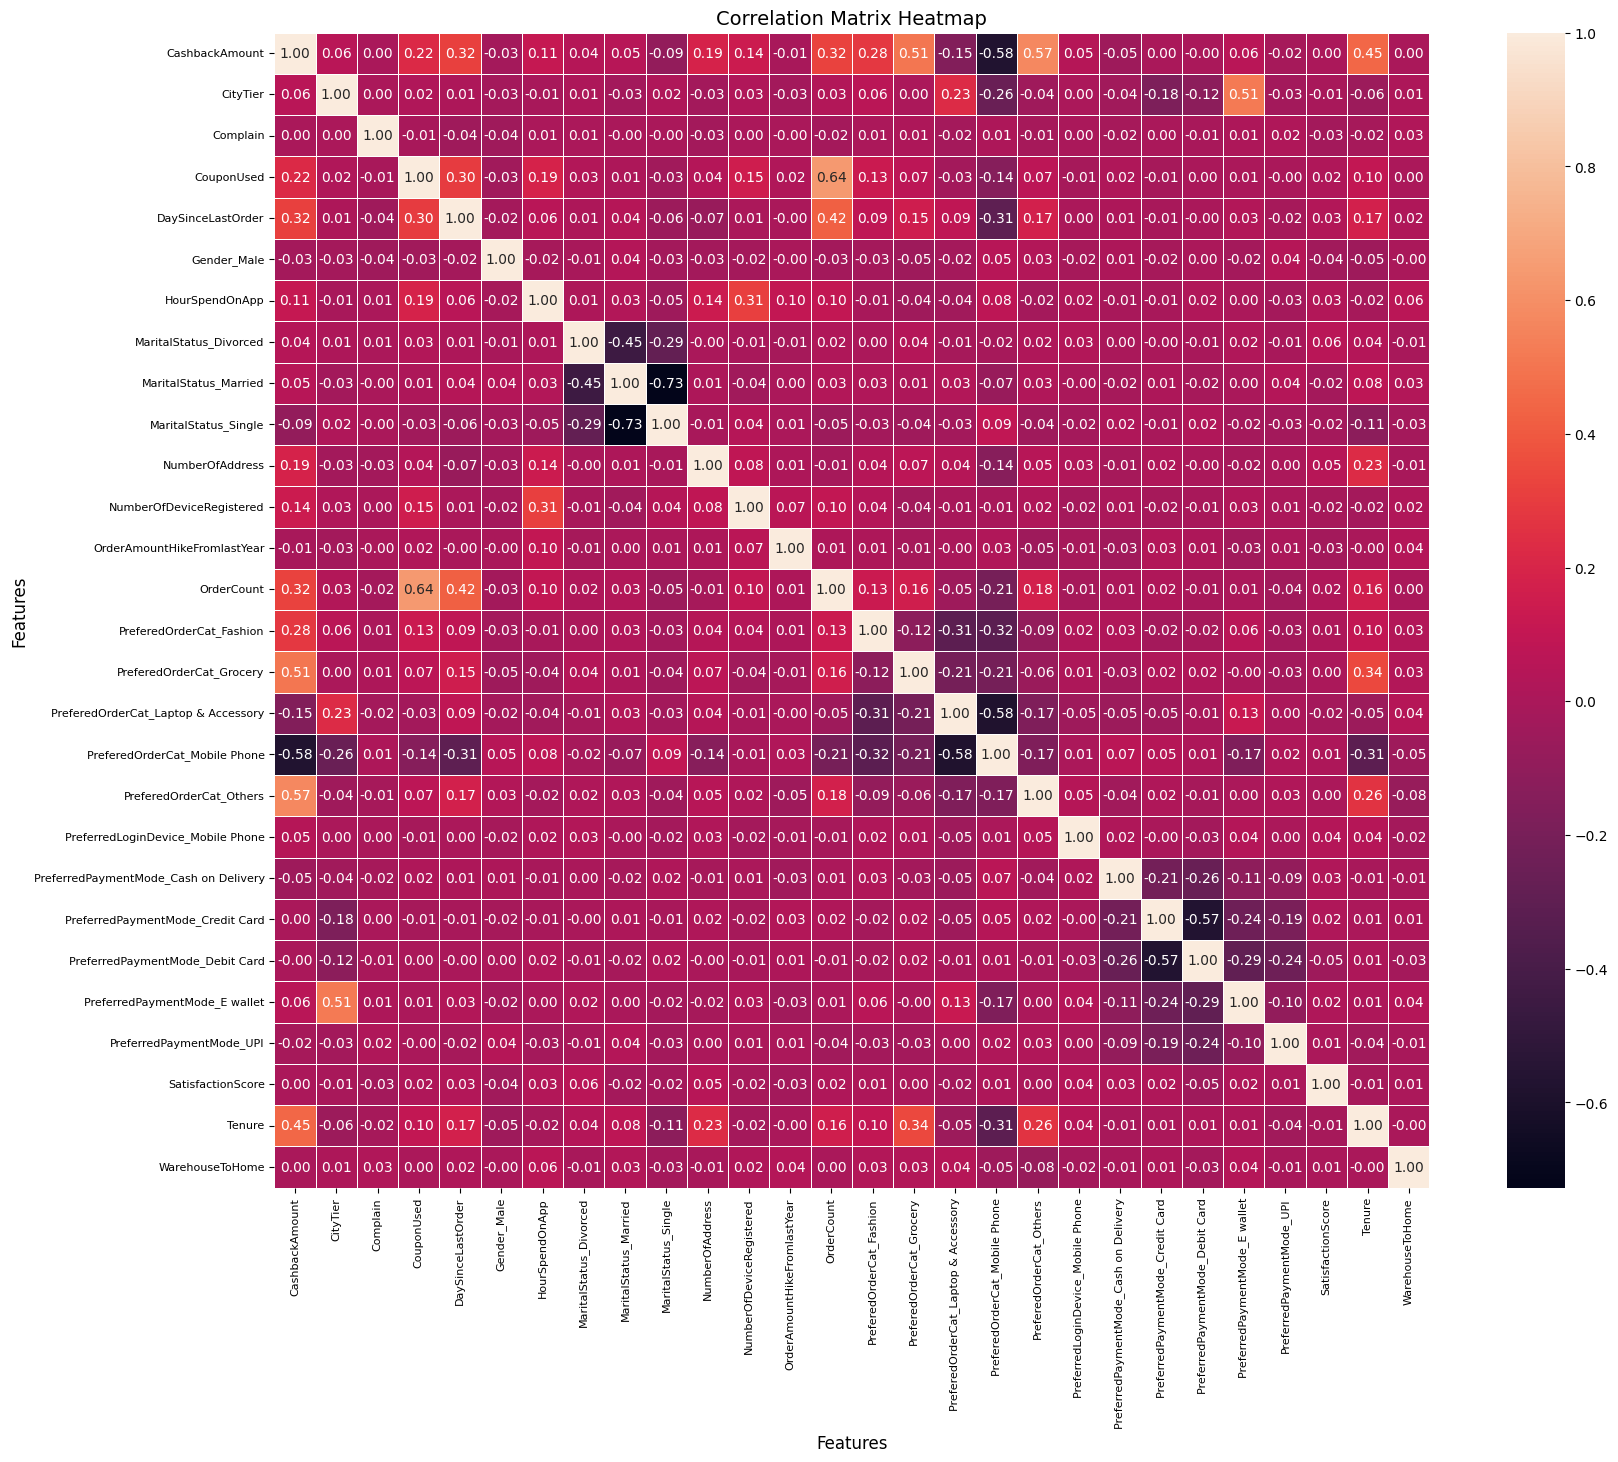

In [56]:
# Calculate the correlation matrix

correlation = df_encoded[numeric_columns].corr()

correlation_values = correlation.values

# Create the heatmap
fig, ax = plt.subplots(figsize=(20, 15))  # Adjust figsize as needed
sns.heatmap(correlation,
            cmap= sns.color_palette("rocket", as_cmap=True),
            linewidths=0.5,
            annot=True,
            fmt='.2f',
            ax=ax)

# Set aspect ratio
ax.set_aspect('equal')

# Adjust font size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Customize labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Correlation Matrix Heatmap', fontsize=14)

# Show the heatmap
plt.show()

# SCALING THE DATA

__Applying Robust Scaling since it is less sensitive to the influence of outliers compared to Min-Max scaling or Standard scaling.__

In [57]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
df_scaled = pd.DataFrame(robust_scaler.fit_transform(df_encoded), columns = df_encoded.columns)

In [58]:
# # visualizing scaled data

# for column in ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
#        'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
#        'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
#        'DaySinceLastOrder', 'CashbackAmount']:


#     # Visualization
#     plt.figure(figsize=(12, 6))

#     # Distribution
#     plt.subplot(1, 2, 1)
#     sns.histplot(df_scaled[column], kde=True, color='blue')
#     plt.title(f'Distribution - {column}')
    
#     # Q-Q plot
#     plt.subplot(1, 2, 2)
#     probplot(df_scaled[column], plot=plt)
#     plt.title(f'Q-Q Plot - {column}')

# MODEL BUILDING AND EVALUATION

In [59]:
# separating features and target variables

X = df_encoded.drop("Churn", axis=1)
X_scaled = df_scaled.drop("Churn", axis=1)
y = df_encoded["Churn"]

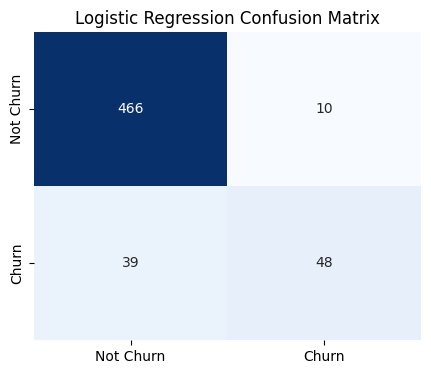


Logistic Regression - Validation Set:
  Accuracy: 0.9130
  Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       476
           1       0.83      0.55      0.66        87

    accuracy                           0.91       563
   macro avg       0.88      0.77      0.81       563
weighted avg       0.91      0.91      0.91       563
 



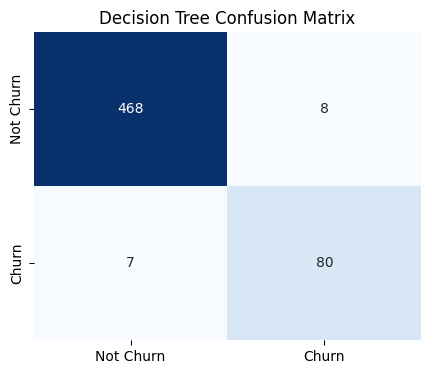


Decision Tree - Validation Set:
  Accuracy: 0.9734
  Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       476
           1       0.91      0.92      0.91        87

    accuracy                           0.97       563
   macro avg       0.95      0.95      0.95       563
weighted avg       0.97      0.97      0.97       563
 



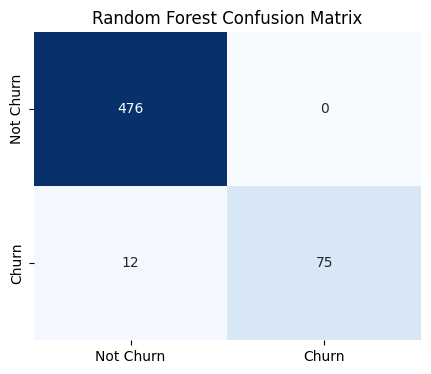


Random Forest - Validation Set:
  Accuracy: 0.9787
  Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       476
           1       1.00      0.86      0.93        87

    accuracy                           0.98       563
   macro avg       0.99      0.93      0.96       563
weighted avg       0.98      0.98      0.98       563
 



In [60]:
# Splitting the dataset into training, validation, and testing sets (80/10/10)

from sklearn import preprocessing
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Train, test, validate (80-10-10) split for the original data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train, test, validate (80-10-10) split for the scaled data
X_scaled_train, X_scaled_temp, y_scaled_train, y_scaled_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_scaled_val, X_scaled_test, y_scaled_val, y_scaled_test = train_test_split(X_scaled_temp, y_scaled_temp, test_size=0.5, random_state=42)

# Logistic Regression 
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_scaled_train, y_train)

# Decision Tree 
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Random Forest 
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Evaluate models on validation set
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churn", "Churn"],
                yticklabels=["Not Churn", "Churn"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    print(f"\n{model_name} - Validation Set:")
    print(f"  Accuracy: {accuracy:.4f}")
    print("  Classification Report:")
    print(classification_report(y_val, y_pred), "\n")


# Evaluate Logistic Regression model
evaluate_model(logistic_model, X_scaled_val, y_val, "Logistic Regression")

# Evaluate Decision Tree model
evaluate_model(decision_tree_model, X_val, y_val, "Decision Tree")

# Evaluate Random Forest model
evaluate_model(random_forest_model, X_val, y_val, "Random Forest")

__Random Forest has the best accuracy (97.8%), as compared to Logistic Regression(91.3%) and Decision Trees (97.3%).__

__CHECKING MODEL FITNESS__

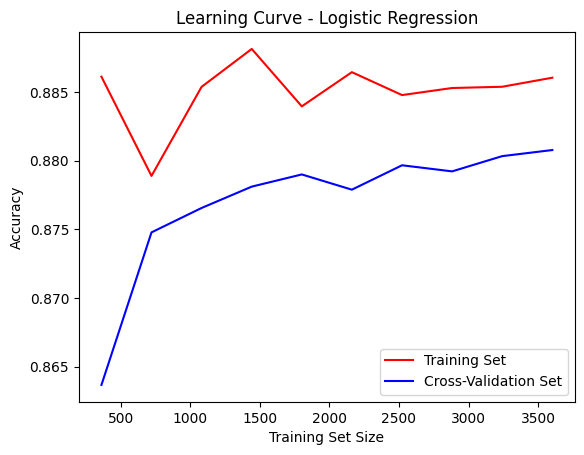

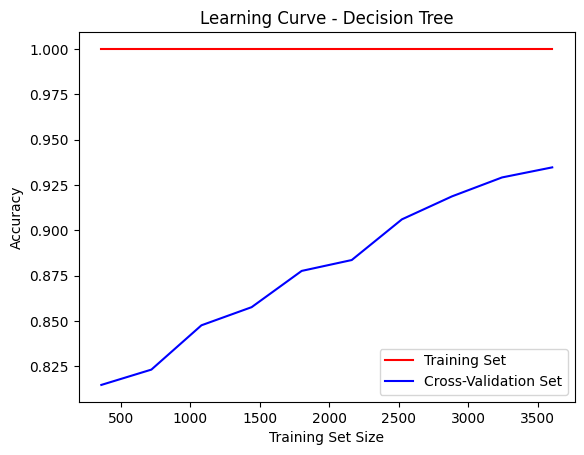

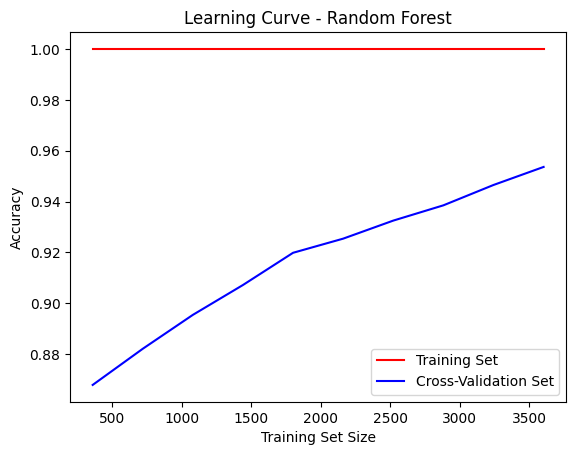

In [61]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='accuracy', n_jobs=-1
    )

    plt.plot(train_sizes, np.mean(train_scores, axis=1), "r-", label="Training Set")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "b-", label="Cross-Validation Set")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    plt.show()


plot_learning_curve(logistic_model, X_scaled_train, y_scaled_train, "Logistic Regression")
plot_learning_curve(decision_tree_model, X_train, y_train, "Decision Tree")
plot_learning_curve(random_forest_model, X_train, y_train, "Random Forest")

__Random Forest has the best performance among the three models.__ 

__It seems that decision trees and random forest are overfitting on the training data. Thus, trying XGBoost as well.__

In [63]:
from xgboost import XGBClassifier 

xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)  # Set objective for binary classification
xgb_model.fit(X_scaled_train, y_scaled_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

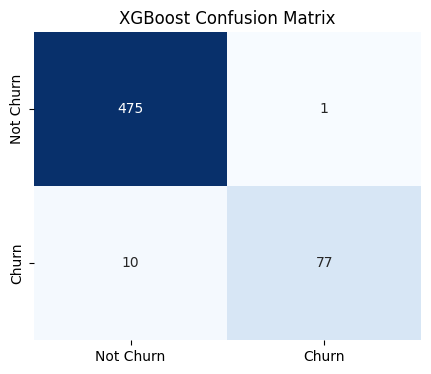


XGBoost - Validation Set:
  Accuracy: 0.9805
  Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       476
           1       0.99      0.89      0.93        87

    accuracy                           0.98       563
   macro avg       0.98      0.94      0.96       563
weighted avg       0.98      0.98      0.98       563
 



In [64]:
# Evaluate XGBoost model
evaluate_model(xgb_model, X_scaled_val, y_val, "XGBoost")

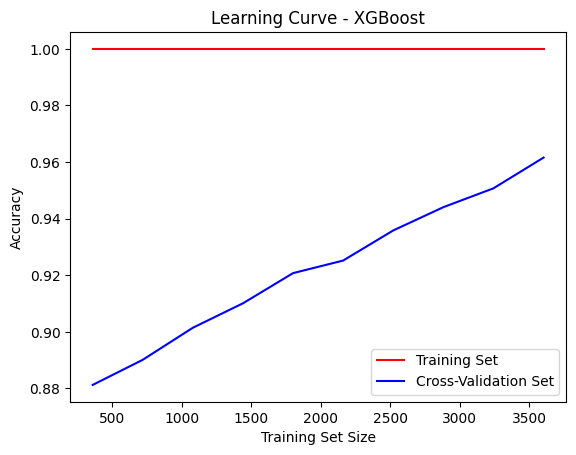

In [65]:
# XGBoost learning curve
plot_learning_curve(xgb_model, X_scaled_train, y_scaled_train, "XGBoost")

__Since XGBoost is offering the best performance, I'll be selecting it as the go-to model and integrate it with the UI.__

# SAVING AND REGISTERING THE ML MODEL

__Saving the model in a cloud storage bucket.__

In [66]:
import joblib

# Save model to a local file
joblib.dump(xgb_model, 'xgboost_model_v1-0.pkl')

# Upload model to storage bucket
bucket = gcs.bucket('ecom_deployment_bucket')
blob = bucket.blob('xgboost_model_v1-0.pkl')
blob.upload_from_filename('xgboost_model_v1-0.pkl')

In [67]:
# # Generating the requirements file

# #!pip install pipreqs

# !pipreqs

__Registering the model in Model Registry.__

In [73]:
# from google.cloud import aiplatform

# # Create a model resource in the model registry
# model_resource_name = f'projects/{PROJECT_ID}/locations/{REGION}/models/random_forest_model_v1-0.pkl'
# model_resource = aiplatform.Model.upload(
#     display_name='Random Forest Model',
#     artifact_uri='gs://ecom_deployment_bucket/random_forest_model_v1-0.pkl',
#     framework='scikit-learn')